In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from Models import tcn
from train.Dataset import CustomDataset
from train.TrainHelpers import train_model, plot_loss_graph, encode_data, train_svm
from train.TestHelpers import test_model, calculate_accuracy

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [2]:
### PARAMETERS ###
dataset_ver = '3w05s_Larm'
n_input = 9
n_hidden = 360

x_train = np.load(f'Generated_Datasets/train_data_{dataset_ver}.npy')
x_val = np.load(f'Generated_Datasets/val_data_{dataset_ver}.npy')
x_test = np.load(f'Generated_Datasets/test_data_{dataset_ver}.npy')

y_train = np.load(f'Generated_Datasets/train_labels_{dataset_ver}.npy')
y_val = np.load(f'Generated_Datasets/val_labels_{dataset_ver}.npy')
y_test = np.load(f'Generated_Datasets/test_labels_{dataset_ver}.npy')

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)

(15407, 60, 9)
(15407,)
(2202, 60, 9)


(15407, 60, 9) (4403, 60, 9) (2202, 60, 9)


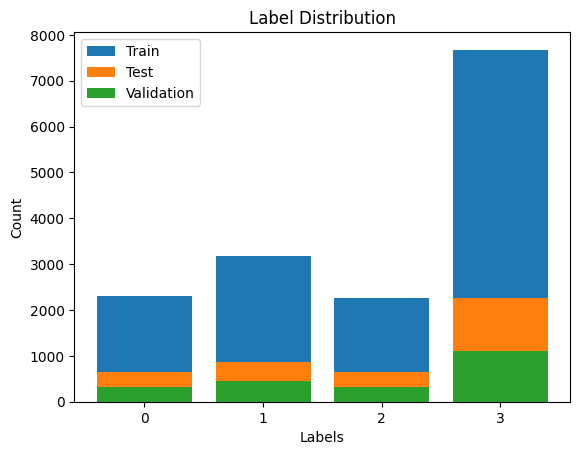

In [4]:
# Check Dataset
print(x_train.shape, x_test.shape, x_val.shape)
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.legend()
plt.show()

In [5]:
### Declare Dataloaders
train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataset = CustomDataset("val", dataset_ver)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)
test_dataset = CustomDataset("test", dataset_ver)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [6]:
for X, y in train_dataloader:
    print(f'{X.shape=}')
    print(f'{y.shape=}')
    break   

X.shape=torch.Size([1, 60, 9])
y.shape=torch.Size([1])


In [7]:
class tcn_classifier(nn.Module):
    def __init__(self, num_inputs, tcn_channels):
        super(tcn_classifier, self).__init__()

        # if tcn_channels[-1] != mlp_layer_dims[0]:
        #     raise ValueError("Output of TCN must match input to MLP!")

        self.tcn = tcn.TCN(num_inputs=num_inputs,
                            num_channels=tcn_channels,
                            causal=True,
                            input_shape='NLC')
        # self.mlp = nn.Sequential()

        # for i in range(len(mlp_layer_dims)-1):
        #     self.mlp.add_module(f'fc{i+1}', nn.Linear(mlp_layer_dims[i], mlp_layer_dims[i+1]))


    def forward(self, x):
        x = self.tcn(x)
        # x = self.mlp(x)
        # print(x.shape)
        return x[0][-1]

In [8]:
tcn_model = tcn_classifier(9, [128, 64, 32, 16, 4])

In [9]:
print(tcn_model)

tcn_classifier(
  (tcn): TCN(
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): ParametrizedCausalConv1d(
          9, 128, kernel_size=(4,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (conv2): ParametrizedCausalConv1d(
          128, 128, kernel_size=(4,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (downsample): Conv1d(9, 128, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
        (conv1): ParametrizedCausalConv1d(
          128, 64, kernel_size=(4,), stride=(1,), dilation=(2,)
          (parametriz

In [12]:
for X, y in train_dataloader:
    out = tcn_model.forward(X)
    print(out.shape)
    break   

torch.Size([4])


In [18]:
def train_TCN(model, learning_rate, num_epochs):
    optimizer = optim.Adam(model.parameters(),
                            lr=learning_rate,
                            betas=(0.9, 0.999),
                            eps=1e-8)

    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Starting Epoch {epoch+1}...')
        model.train()

        for train_X, train_y in tqdm(train_dataloader):
            optimizer.zero_grad()
            
            train_output = model(train_X)

            train_loss = criterion(train_output, train_y[0].type(torch.LongTensor))
            train_loss.backward()
            optimizer.step()
        
        train_losses.append(train_loss.item())
        print(f'Train Loss = {train_losses[-1]}')

        model.eval()
        for val_X, val_y in tqdm(val_dataloader):
            val_output = model(val_X)
        
        val_losses.append(criterion(val_output, val_y[0].type(torch.LongTensor)))
        print(f'Val Loss = {val_losses[-1]}')

    return train_losses, val_losses


In [17]:
train_losses, val_losses = train_TCN(tcn_model, 1e-3, 5)

Starting Epoch 1...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 1.0785067081451416


  0%|          | 0/2202 [00:00<?, ?it/s]

NameError: name 'val_loss' is not defined